In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression

In [5]:
path = 'C:\\Users\\user\\Desktop\\python\\'

In [6]:
df_betfair = pd.read_csv(path + 'betfair_clean.csv')
df_betfair.EVENT_DT = pd.to_datetime(df_betfair.EVENT_DT).dt.normalize()

In [7]:
columns = ['Date','Country','Track','Going','Type','Distance','Class','Time','Stall','Horse','OR','Age','Pace','Weight',
'Jockey','Trainer','Head Gear','SP Fav','Industry SP','Betfair SP','IP Min','IP Max','Pre Min','Pre Max',
'Pred Industry SP','Place','Winning Distance','Runners','SP Win Return','E/W return','BF Win Return','minus',
'plus','percentage_minus','percentage_plus']

df = pd.read_csv(path + 'horses_clean.csv', index_col = 0)
df.columns = columns

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df.head().T

,0,1,2,3,4
Date,2010-02-20,2010-02-20,2010-02-20,2010-02-20,2010-02-20
Country,GB,GB,GB,GB,GB
Track,ASCOT,ASCOT,ASCOT,ASCOT,ASCOT
Going,GTS,GTS,GTS,GTS,GTS
Type,Hurdle,Hurdle,Hurdle,Hurdle,Hurdle
Distance,2m3½f,2m3½f,2m3½f,2m3½f,2m3½f
Class,3,3,3,3,3
Time,1:40pm,1:40pm,1:40pm,1:40pm,1:40pm
Stall,NaN,NaN,NaN,NaN,NaN
Horse,FINIANS RAINBOW,SERETH,SPIRIT OF ADJISA,ARKOSE,PRIORS GLEN


##### Compare public odds vs actual by breaking up into histograms

In [12]:
dfclean = df.loc[df['Betfair SP'] > 0]
dfclean['prob'] = 1/dfclean['Betfair SP']

nbuckets = 20
dfclean['buckets'] = pd.cut(dfclean['prob'], nbuckets, labels=False) 
dictionary = dict(zip([i for i in range(nbuckets)], np.linspace(0,1, num = nbuckets)))
dfclean['buckets'] = dfclean['buckets'].map(dictionary)
dfclean['win'] = (dfclean['Place'] == '1')*1
dfclean = dfclean.loc[dfclean.buckets < 0.6] # Only consider up to 0.6 implied odds. 
publicvsactual = dfclean.groupby(['buckets']).win.sum()/dfclean.groupby(['buckets']).win.count()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

##### Wow the public's estimate on average is pretty darn good!

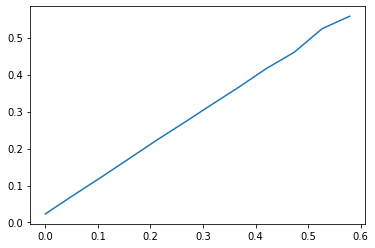

In [13]:
plt.plot(publicvsactual)

The result above matches Benter, W (1994). So public estimate needs to be included as one of the covariates. 
Bear in mind this chart is only averaged out and likely has considerable variance which can be exploited.

In [10]:
def get_pct(price):
    horse_pct = df_betfair.groupby(['EVENT_ID', 'SELECTION_NAME'])[price].sum()
    horse_pct = horse_pct.groupby(['SELECTION_NAME']).mean()
    
    return horse_pct

horse_ppwap_pct = get_pct('PPWAP')
horse_bsp_pct = get_pct('BSP')

horse_win_sum = df_betfair.groupby(['SELECTION_NAME'])['WIN_LOSE'].sum()
horse_race_sum = df_betfair.groupby(['SELECTION_NAME'])['WIN_LOSE'].count()
horse_win_pct = horse_win_sum/horse_race_sum

# Only pick horses with 20 races or more
horses_shortlist = horse_race_sum.loc[horse_race_sum > 20].keys()
temp = pd.DataFrame([horse_win_pct.loc[horses_shortlist], horse_ppwap_pct.loc[horses_shortlist]]).T
temp2 = pd.DataFrame([horse_win_pct.loc[horses_shortlist], horse_bsp_pct.loc[horses_shortlist]]).T

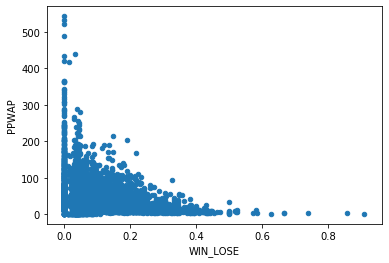

In [11]:
temp.plot.scatter('WIN_LOSE', 'PPWAP')

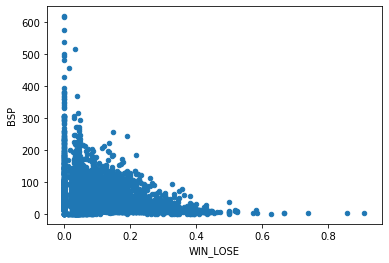

In [12]:
temp2.plot.scatter('WIN_LOSE', 'BSP')